In [1]:
from salishsea_tools import nc_tools, data_tools, tidetools, visualisations, viz_tools, stormtools, geo_tools
from collections     import OrderedDict
from matplotlib      import pyplot, animation, rcParams, patches
from dateutil        import parser
import datetime
import os
import numpy as np
import xarray

%matplotlib inline
rcParams.update({'font.size': 12})
rcParams["axes.formatter.useoffset"] = False

In [2]:
timerange = ['2016 Mar 1 00:00', '2016 Mar 31 00:00']
starttime, endtime = map(parser.parse, timerange)

In [3]:
NEMO = nc_tools.load_NEMO_from_erddap(timerange, depth=[0, 1]).isel(depth=0)
GEM  = nc_tools.load_GEM_from_erddap( timerange)

In [4]:
Stations = [
    'PamRocks',
    'SistersIsland',
    'EntranceIsland',
    'Sandheads',
    'YVR',
    'PointAtkinson',
    'Victoria',
    'CampbellRiver',
    'PatriciaBay',
    'Esquimalt',
]

i_shift = [0, 0, 0, 0, -2, 0,  0, 3, -1,  0]
j_shift = [0, 0, 0, 0,  0, 0, -1, 0,  2, -1]

EC_wind = {}

for index, station in enumerate(Stations):
    
    DATA = stormtools.get_EC_observations(station,
                               datetime.datetime.strftime(starttime, '%d-%b-%Y'),
                               datetime.datetime.strftime(endtime,   '%d-%b-%Y'))
    
    j, i = geo_tools.find_closest_model_point(
    DATA[5], DATA[4], GEM.longitude, GEM.latitude, grid='GEM2.5')
    
    EC_wind[station] = xarray.Dataset({
                'lon'    : DATA[5],
                'lat'    : DATA[4],
                'i_coord': i + i_shift[index],
                'j_coord': j + j_shift[index],
                'windspd': ('time', DATA[0]),
                'winddir': ('time', DATA[1]),
                'u_wind' : ('time', -1 * DATA[0] * np.cos(np.radians(DATA[1]))),
                'v_wind' : ('time', -1 * DATA[0] * np.sin(np.radians(DATA[1])))},      
                coords={'time': DATA[3]})

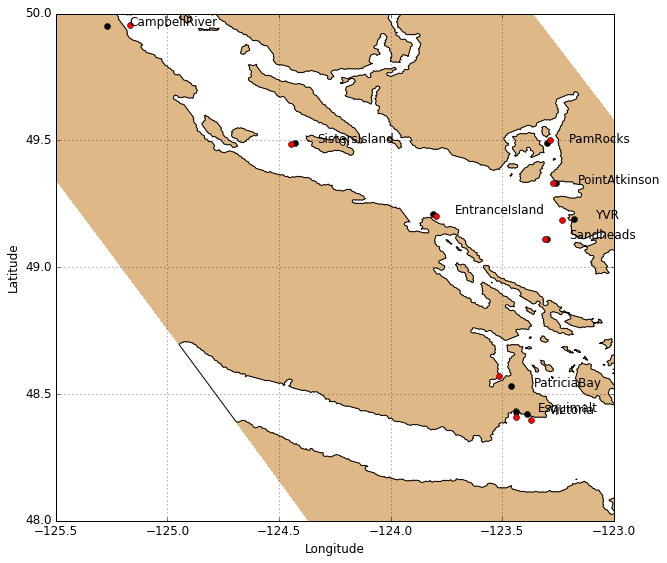

In [5]:
# Create figure
fig, ax = pyplot.subplots(1, 1, figsize=(10, 10))
visualisations.create_figure(ax, NEMO.isel(time=0), window=[-125.5, -123, 48, 50])
for station in Stations:
    i = EC_wind[station].i_coord.values.item()
    j = EC_wind[station].j_coord.values.item()
    pyplot.plot(EC_wind[station].lon, EC_wind[station].lat, 'ko')
    pyplot.plot(GEM.longitude.isel(gridX=i, gridY=j), GEM.latitude.isel(gridX=i, gridY=j), 'ro')
    ax.text(EC_wind[station].lon+.1, EC_wind[station].lat, station)

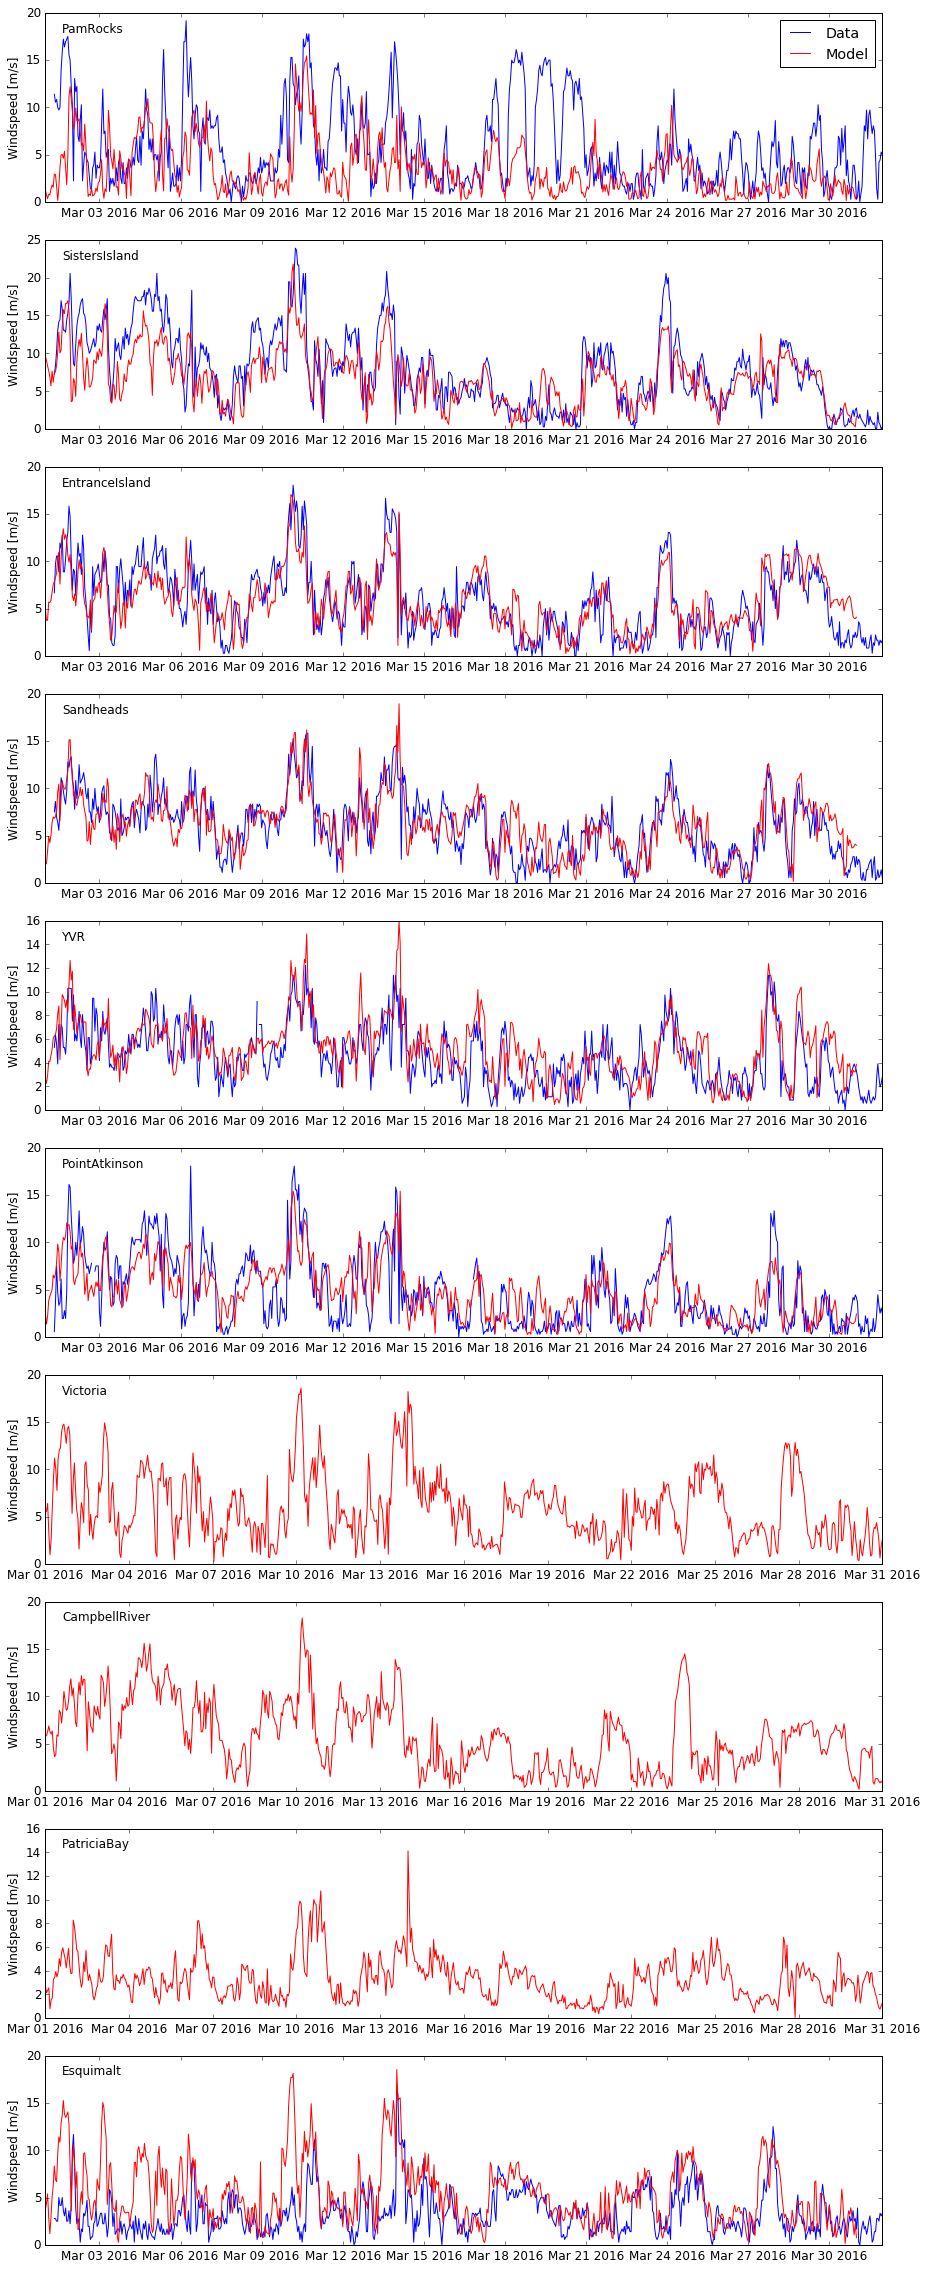

In [6]:
fig, ax = pyplot.subplots(10, 1, figsize=(15, 40))

for index, station in enumerate(Stations):
    i = EC_wind[station].i_coord.values.item()
    j = EC_wind[station].j_coord.values.item()
    ax[index].plot(EC_wind[station].time, EC_wind[station].windspd, 'b-')
    ax[index].plot(GEM.time, np.sqrt(GEM.u_wind.isel(gridX=i, gridY=j)**2 + GEM.v_wind.isel(gridX=i, gridY=j)**2), 'r-')
    ax[index].text(0.02, 0.9, station, transform=ax[index].transAxes)
    ax[index].set_ylabel('Windspeed [m/s]')
    
ax[0].legend(labels=['Data', 'Model'])

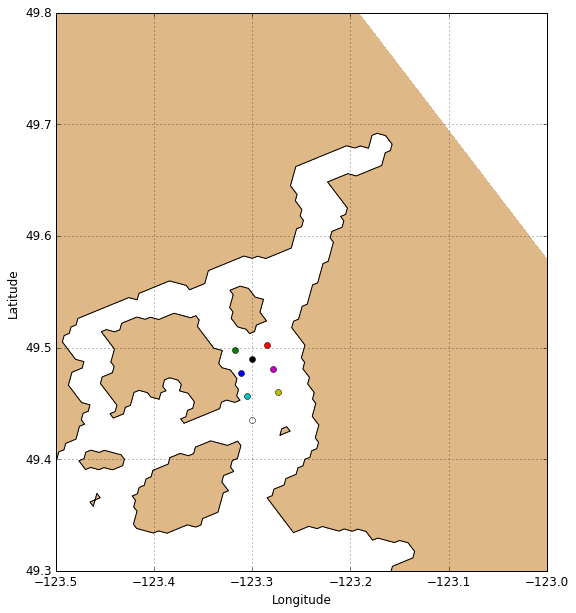

In [7]:
# Create figure
fig, ax = pyplot.subplots(1, 1, figsize=(10, 10))
visualisations.create_figure(ax, NEMO.isel(time=0), window=[-123.5, -123.0, 49.3, 49.8])

i = EC_wind['PamRocks'].i_coord.values.item()
j = EC_wind['PamRocks'].j_coord.values.item()
pyplot.plot(EC_wind['PamRocks'].lon, EC_wind['PamRocks'].lat, 'ko')

pyplot.plot(GEM.longitude.isel(gridX=i, gridY=j), GEM.latitude.isel(gridX=i, gridY=j), 'ro')
pyplot.plot(GEM.longitude.isel(gridX=i-1, gridY=j-1), GEM.latitude.isel(gridX=i-1, gridY=j-1), 'bo')
pyplot.plot(GEM.longitude.isel(gridX=i-1, gridY=j), GEM.latitude.isel(gridX=i-1, gridY=j), 'go')
pyplot.plot(GEM.longitude.isel(gridX=i, gridY=j-1), GEM.latitude.isel(gridX=i, gridY=j-1), 'mo')
pyplot.plot(GEM.longitude.isel(gridX=i-1, gridY=j-2), GEM.latitude.isel(gridX=i-1, gridY=j-2), 'co')
pyplot.plot(GEM.longitude.isel(gridX=i, gridY=j-2), GEM.latitude.isel(gridX=i, gridY=j-2), 'yo')
pyplot.plot(GEM.longitude.isel(gridX=i-1, gridY=j-3), GEM.latitude.isel(gridX=i-1, gridY=j-3), 'wo')

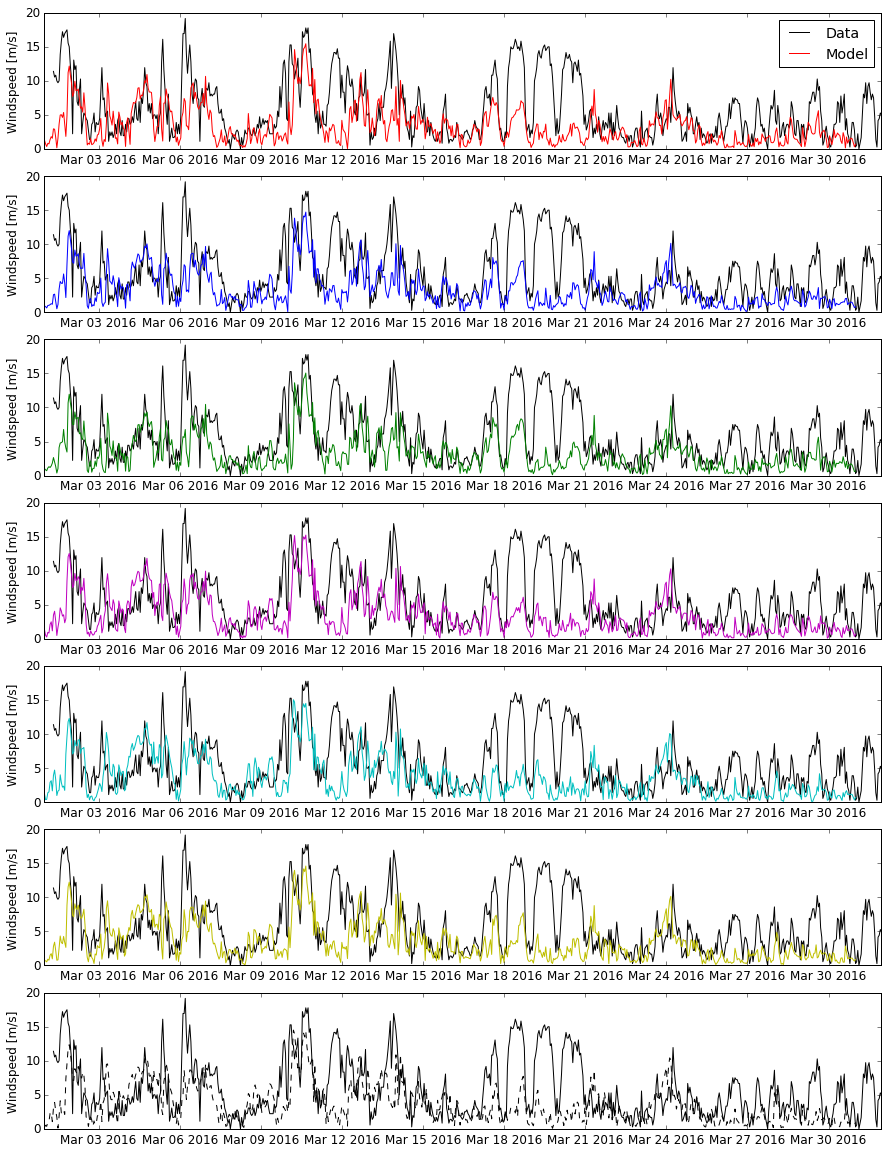

In [8]:
fig, ax = pyplot.subplots(7, 1, figsize=(15, 20))

i = EC_wind['PamRocks'].i_coord.values.item()
j = EC_wind['PamRocks'].j_coord.values.item()

ax[0].plot(EC_wind['PamRocks'].time, EC_wind['PamRocks'].windspd, 'k-')
ax[0].plot(GEM.time, np.sqrt(GEM.u_wind.isel(gridX=i, gridY=j)**2 + GEM.v_wind.isel(gridX=i, gridY=j)**2), 'r-')
ax[0].set_ylabel('Windspeed [m/s]')
ax[0].legend(labels=['Data', 'Model'])

ax[1].plot(EC_wind['PamRocks'].time, EC_wind['PamRocks'].windspd, 'k-')
ax[1].plot(GEM.time, np.sqrt(GEM.u_wind.isel(gridX=i-1, gridY=j-1)**2 + GEM.v_wind.isel(gridX=i-1, gridY=j-1)**2), 'b-')
ax[1].set_ylabel('Windspeed [m/s]')

ax[2].plot(EC_wind['PamRocks'].time, EC_wind['PamRocks'].windspd, 'k-')
ax[2].plot(GEM.time, np.sqrt(GEM.u_wind.isel(gridX=i-1, gridY=j)**2 + GEM.v_wind.isel(gridX=i-1, gridY=j)**2), 'g-')
ax[2].set_ylabel('Windspeed [m/s]')

ax[3].plot(EC_wind['PamRocks'].time, EC_wind['PamRocks'].windspd, 'k-')
ax[3].plot(GEM.time, np.sqrt(GEM.u_wind.isel(gridX=i, gridY=j-1)**2 + GEM.v_wind.isel(gridX=i, gridY=j-1)**2), 'm-')
ax[3].set_ylabel('Windspeed [m/s]')

ax[4].plot(EC_wind['PamRocks'].time, EC_wind['PamRocks'].windspd, 'k-')
ax[4].plot(GEM.time, np.sqrt(GEM.u_wind.isel(gridX=i, gridY=j-2)**2 + GEM.v_wind.isel(gridX=i, gridY=j-2)**2), 'c-')
ax[4].set_ylabel('Windspeed [m/s]')

ax[5].plot(EC_wind['PamRocks'].time, EC_wind['PamRocks'].windspd, 'k-')
ax[5].plot(GEM.time, np.sqrt(GEM.u_wind.isel(gridX=i-1, gridY=j-2)**2 + GEM.v_wind.isel(gridX=i-1, gridY=j-2)**2), 'y-')
ax[5].set_ylabel('Windspeed [m/s]')

ax[6].plot(EC_wind['PamRocks'].time, EC_wind['PamRocks'].windspd, 'k-')
ax[6].plot(GEM.time, np.sqrt(GEM.u_wind.isel(gridX=i-1, gridY=j-3)**2 + GEM.v_wind.isel(gridX=i-1, gridY=j-3)**2), 'k--')
ax[6].set_ylabel('Windspeed [m/s]')